In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Accumulation phase CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
test_data = {}

for name in test_sets:

    df = pd.read_csv("{}/test_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    test_data['{}_X'.format(name)] = X
    test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0
            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0
            previous_1d      EMA_12   willr_14        OBV_7  labels
D

## Train Accumulation Phase Stock Data

In [6]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [7]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [8]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

accumulation phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2001-01-08      22.3125  19.936626 -15.972222   192400.0     2.0
2001-01-09      20.5625  20.032914 -35.416667 -1320000.0     2.0
2001-01-10      20.7500  20.143235 -33.333333  -439800.0     2.0
2001-01-11      21.1250  20.294276 -29.166667   290200.0     2.0
2001-01-12      22.6875  20.662464 -13.178295  1360200.0     2.0


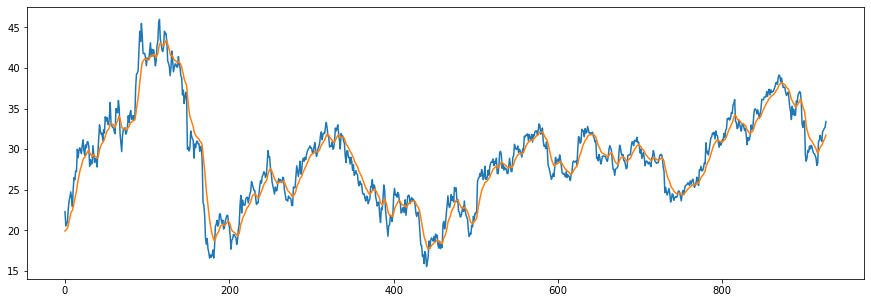

accumulation phase data\1_acc_data.csv
            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2013-10-21   122.519997  119.133586  -3.571469  268371800.0     2.0
2013-10-22   121.470001  119.493034 -14.600827  265163900.0     2.0
2013-10-23   122.480003  119.952568 -12.619492  269595100.0     2.0
2013-10-24   129.020004  121.347558  -5.825830  280361400.0     2.0
2013-10-25   128.979996  122.521779  -6.066121  275385200.0     2.0


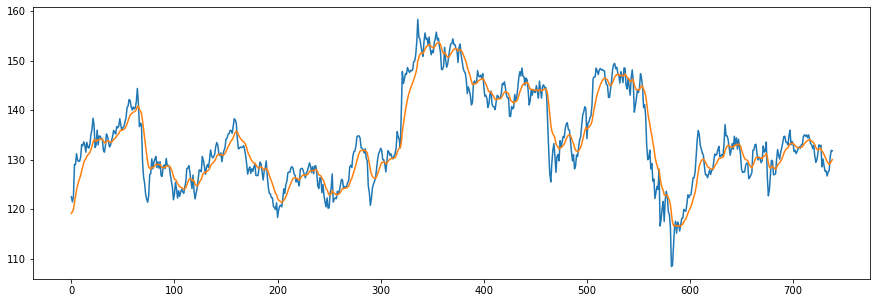

accumulation phase data\2_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2011-06-02    16.940001  16.497632 -20.155042  9.557743e+09     2.0
2011-06-03    16.990000  16.573381 -24.475546  9.575374e+09     2.0
2011-06-07    17.440001  16.706707 -22.334963  9.601214e+09     2.0
2011-06-08    17.350000  16.805675 -26.903501  9.588997e+09     0.0
2011-06-09    17.760000  16.952494  -6.091318  9.611336e+09     2.0


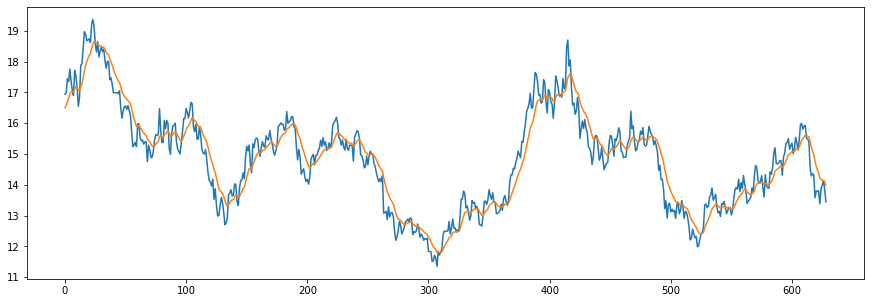

accumulation phase data\3_acc_data.csv
            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-08-30     6.405571  6.389804 -28.571449  273414472.0     2.0
2004-08-31     6.405571  6.392230 -28.571449  273414472.0     2.0
2004-09-01     6.454098  6.401748 -19.999921  278125245.0     2.0
2004-09-02     6.551152  6.424733  -0.000000  288787337.0     2.0
2004-09-03     6.599679  6.451648  -0.000000  306525894.0     2.0


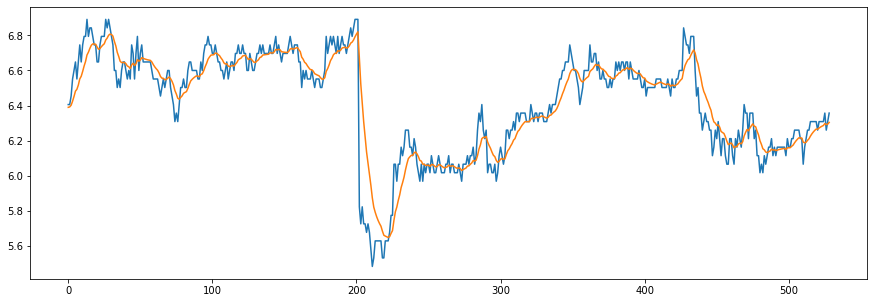

accumulation phase data\4_acc_data.csv
            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2009-08-03    38.650002  37.415266 -15.157111 -1.307058e+09     2.0
2009-08-04    39.599998  37.751379  -3.164588 -1.264100e+09     2.0
2009-08-05    40.209999  38.129628  -5.492443 -1.220737e+09     2.0
2009-08-06    41.779999  38.691224  -6.976777 -1.157402e+09     2.0
2009-08-07    40.750000  39.007958 -27.359985 -1.211578e+09     2.0


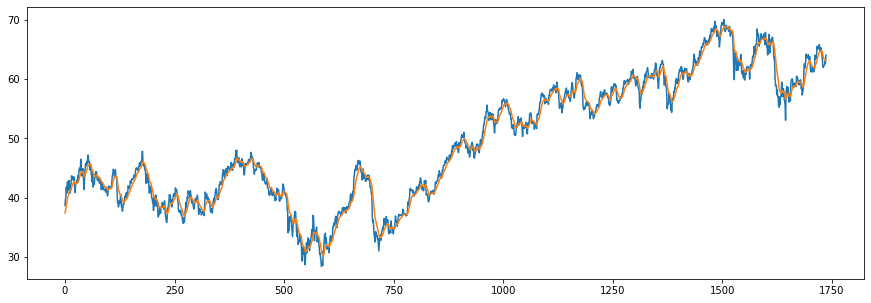

In [9]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

for filepath in glob.iglob('accumulation phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

In [10]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4491, 15, 1)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [12]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4491, 64, 64, 1)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 4094, 0.0: 194, 1.0: 203})

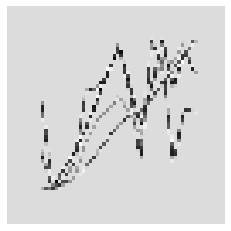

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['accumulation phase data','mark up phase data','distribution phase data','mark down phase data','bull phase data','bear phase data','full cycle data']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        X = test_data['{}_X'.format(name)]
        y = test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("{}/test_data.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(log)
        log.loc[df_length] = logger
        print(log.head(20))
        logger = []

    log.to_csv('{}_{}epochs.csv'.format(experiment,epochs))
    log_hist['{}_epochs_logs'.format(epochs)] = log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 0 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.724731182795699, 1: 7.390946502057613, 2: 0.3655979643765903}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/29 [>.............................] - ETA: 0s - loss: 0.3458 - accuracy: 0.6875 - mse: 5.5061 - weighted_accuracy: 0.4211 - weighted_mse: 5.3540WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 1s 47ms/step - loss: 0.2359 - accuracy: 0.3126 - mse: 1.6574 - weighted_accuracy: 0.3634 - weighted_mse: 1.6263 - val_loss: 0.2246 - val_accuracy: 0.0423 - val_mse: 1.0181 - val_weighted_accuracy: 0.0423 - val_weighted_mse: 1.0181
Epoch 2/20
29/29 [==============================] - 1s 23ms/step - loss: 0.2125 - accuracy: 0.1893 - mse: 1.2371 - weighted_accuracy: 0.3188 - weighted_mse: 1.2075 - val_loss: 0.2160 -

7/7 [==============================] - 0s 22ms/step - loss: 0.1998 - accuracy: 0.3379 - mse: 0.8693 - weighted_accuracy: 0.3379 - weighted_mse: 0.8693
Test loss: 0.19978520274162292
Test accuracy: 0.3378995358943939


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 104
actual holds but predicted sell: 32
actual predicted holds: 65
Percentage buys correct: 5.3097345132743365%
Percentage sells correct: 8.571428571428571%
Percentage holds correct: 91.54929577464789%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 46.42857142857143%
Percentage high sells correct: 48.57142857142857%
Percentage mid holds correct: 87.32394366197182%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Pri

9/9 [==============================] - 0s 4ms/step - loss: 0.2011 - accuracy: 0.2482 - mse: 0.8979 - weighted_accuracy: 0.2482 - weighted_mse: 0.8979
Test loss: 0.2010849416255951
Test accuracy: 0.24820144474506378


number of predictions: 278
actual predicted buys: 13
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 156
actual holds but predicted sell: 40
actual predicted holds: 53
Percentage buys correct: 7.428571428571429%
Percentage sells correct: 6.521739130434782%
Percentage holds correct: 92.98245614035088%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 41.37931034482759%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 91.2280701754386%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase fro

19/19 [==============================] - 0s 13ms/step - loss: 0.2003 - accuracy: 0.2857 - mse: 0.8803 - weighted_accuracy: 0.2857 - weighted_mse: 0.8803
Test loss: 0.200343057513237
Test accuracy: 0.2857142984867096


number of predictions: 595
actual predicted buys: 22
actual buys but predicted sell: 8
actual buys but predicted hold: 2
actual sells but predicted buy: 7
actual predicted sells: 8
actual sells but predicted hold: 12
actual holds but predicted buy: 287
actual holds but predicted sell: 109
actual predicted holds: 140
Percentage buys correct: 6.962025316455696%
Percentage sells correct: 6.4%
Percentage holds correct: 90.9090909090909%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 46.03174603174603%
Percentage high sells correct: 41.6%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


Price increase from previous

29/29 [==============================] - 0s 11ms/step - loss: 0.2005 - accuracy: 0.2912 - mse: 0.8806 - weighted_accuracy: 0.2912 - weighted_mse: 0.8806
Test loss: 0.20047052204608917
Test accuracy: 0.29116684198379517


number of predictions: 917
actual predicted buys: 33
actual buys but predicted sell: 5
actual buys but predicted hold: 8
actual sells but predicted buy: 12
actual predicted sells: 10
actual sells but predicted hold: 18
actual holds but predicted buy: 465
actual holds but predicted sell: 142
actual predicted holds: 224
Percentage buys correct: 6.470588235294118%
Percentage sells correct: 6.369426751592357%
Percentage holds correct: 89.6%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 45.383104125736736%
Percentage high sells correct: 35.6687898089172%
Percentage mid holds correct: 85.6%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656


Price increase from pr

Epoch 1/20
29/29 [==============================] - 1s 35ms/step - loss: 0.1980 - accuracy: 0.3867 - mse: 1.1821 - weighted_accuracy: 0.4080 - weighted_mse: 1.1870 - val_loss: 0.2117 - val_accuracy: 0.0712 - val_mse: 0.9658 - val_weighted_accuracy: 0.0712 - val_weighted_mse: 0.9658
Epoch 2/20
29/29 [==============================] - 1s 23ms/step - loss: 0.1963 - accuracy: 0.3026 - mse: 1.1902 - weighted_accuracy: 0.3791 - weighted_mse: 1.1682 - val_loss: 0.2028 - val_accuracy: 0.1746 - val_mse: 0.9935 - val_weighted_accuracy: 0.1746 - val_weighted_mse: 0.9935
Epoch 3/20
29/29 [==============================] - 1s 23ms/step - loss: 0.1997 - accuracy: 0.3068 - mse: 1.2214 - weighted_accuracy: 0.3704 - weighted_mse: 1.1921 - val_loss: 0.1997 - val_accuracy: 0.2970 - val_mse: 0.8168 - val_weighted_accuracy: 0.2970 - val_weighted_mse: 0.8168
Epoch 4/20
29/29 [==============================] - 1s 23ms/step - loss: 0.1970 - accuracy: 0.3460 - mse: 1.1654 - weighted_accuracy: 0.4024 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.2053 - accuracy: 0.0731 - mse: 1.0212 - weighted_accuracy: 0.0731 - weighted_mse: 1.0212
Test loss: 0.20530176162719727
Test accuracy: 0.07305935770273209


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 116
actual holds but predicted sell: 82
actual predicted holds: 3
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 7.777777777777778%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.4%
Percentage high sells correct: 47.77777777777778%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bought: 55.

Share price: $0.9212147800120356
Shares owned at the moment: 0
Cash capital at the moment: $1434.7017273965057


Share price: $0.8238627736004933
Shares owned at the moment: 1736
Cash capital at the moment: $0.5428315448805279


Price increase from previously bought: 18.25985887210104%
Share price: $0.97697827548146
Shares owned at the moment: 0
Cash capital at the moment: $1691.9130234935465


Share price: $0.7723051890330688
Shares owned at the moment: 2184
Cash capital at the moment: $0.5600256799916679


Price increase from previously bought: 25.16906256263971%
Share price: $0.9693455549397119
Shares owned at the moment: 0
Cash capital at the moment: $2111.7888282653544


Share price: $0.9199688834846687
Shares owned at the moment: 2289
Cash capital at the moment: $0.18907983963254082


Price increase from previously bought: -20.181584284304755%
Share price: $0.7363239254914886
Shares owned at the moment: 0
Cash capital at the moment: $1680.9995702596625


Share price: $0.708130822

7/7 [==============================] - 0s 7ms/step - loss: 0.2038 - accuracy: 0.0721 - mse: 1.0296 - weighted_accuracy: 0.0721 - weighted_mse: 1.0296
Test loss: 0.20379015803337097
Test accuracy: 0.07211538404226303


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 4
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 80
actual holds but predicted sell: 108
actual predicted holds: 1
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 5.217391304347826%
Percentage holds correct: 100.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 43.47826086956522%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previou

19/19 [==============================] - 0s 6ms/step - loss: 0.2055 - accuracy: 0.0824 - mse: 1.0333 - weighted_accuracy: 0.0824 - weighted_mse: 1.0333
Test loss: 0.20550650358200073
Test accuracy: 0.08235294371843338


number of predictions: 595
actual predicted buys: 27
actual buys but predicted sell: 5
actual buys but predicted hold: 0
actual sells but predicted buy: 8
actual predicted sells: 19
actual sells but predicted hold: 0
actual holds but predicted buy: 316
actual holds but predicted sell: 217
actual predicted holds: 3
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 7.8838174273858925%
Percentage holds correct: 100.0%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 47.142857142857146%
Percentage high sells correct: 49.79253112033195%
Percentage mid holds correct: 66.66666666666667%


Capital: 100
Share price: $0.7488095723945759
Shares owned at the moment: 133
Cash capital at the moment: $0.1344497704180867


Price inc

29/29 [==============================] - 0s 6ms/step - loss: 0.2058 - accuracy: 0.0894 - mse: 1.0372 - weighted_accuracy: 0.0894 - weighted_mse: 1.0372
Test loss: 0.2058190405368805
Test accuracy: 0.08942202478647232


number of predictions: 917
actual predicted buys: 40
actual buys but predicted sell: 5
actual buys but predicted hold: 1
actual sells but predicted buy: 12
actual predicted sells: 28
actual sells but predicted hold: 0
actual holds but predicted buy: 502
actual holds but predicted sell: 315
actual predicted holds: 14
Percentage buys correct: 7.2202166064981945%
Percentage sells correct: 8.045977011494253%
Percentage holds correct: 93.33333333333333%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 45.56962025316456%
Percentage high sells correct: 47.98850574712644%
Percentage mid holds correct: 86.66666666666667%


Capital: 100
Share price: $0.3610541051067073
Shares owned at the moment: 276
Cash capital at the moment: $0.07502692477278572

Epoch 1/20
29/29 [==============================] - 1s 26ms/step - loss: 0.1820 - accuracy: 0.2305 - mse: 1.3031 - weighted_accuracy: 0.5141 - weighted_mse: 1.2767 - val_loss: 0.2006 - val_accuracy: 0.0912 - val_mse: 1.0916 - val_weighted_accuracy: 0.0912 - val_weighted_mse: 1.0916
Epoch 2/20
29/29 [==============================] - 1s 22ms/step - loss: 0.1848 - accuracy: 0.2350 - mse: 1.2729 - weighted_accuracy: 0.4927 - weighted_mse: 1.2333 - val_loss: 0.1987 - val_accuracy: 0.1190 - val_mse: 1.1494 - val_weighted_accuracy: 0.1190 - val_weighted_mse: 1.1494
Epoch 3/20
29/29 [==============================] - 1s 22ms/step - loss: 0.1828 - accuracy: 0.2394 - mse: 1.3121 - weighted_accuracy: 0.5103 - weighted_mse: 1.2764 - val_loss: 0.2035 - val_accuracy: 0.0768 - val_mse: 1.0903 - val_weighted_accuracy: 0.0768 - val_weighted_mse: 1.0903
Epoch 4/20
29/29 [==============================] - 1s 21ms/step - loss: 0.1810 - accuracy: 0.2091 - mse: 1.3442 - weighted_accuracy: 0.5121 - weighted

0          82.557937  


mark up phase data


7/7 [==============================] - 0s 8ms/step - loss: 0.2002 - accuracy: 0.1553 - mse: 1.2319 - weighted_accuracy: 0.1553 - weighted_mse: 1.2319
Test loss: 0.20017868280410767
Test accuracy: 0.155251145362854


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 75
actual holds but predicted sell: 105
actual predicted holds: 21
Percentage buys correct: 6.024096385542169%
Percentage sells correct: 7.079646017699115%
Percentage holds correct: 91.30434782608695%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.80722891566265%
Percentage high sells correct: 44.24778761061947%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital

9/9 [==============================] - 0s 6ms/step - loss: 0.1985 - accuracy: 0.1439 - mse: 1.2060 - weighted_accuracy: 0.1439 - weighted_mse: 1.2060
Test loss: 0.1985033005475998
Test accuracy: 0.14388489723205566


number of predictions: 278
actual predicted buys: 13
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 10
actual sells but predicted hold: 0
actual holds but predicted buy: 124
actual holds but predicted sell: 108
actual predicted holds: 17
Percentage buys correct: 9.285714285714286%
Percentage sells correct: 8.403361344537815%
Percentage holds correct: 89.47368421052632%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 45.32374100719424%
Percentage high sells correct: 47.05882352941177%
Percentage mid holds correct: 84.21052631578948%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Pr

7/7 [==============================] - 0s 5ms/step - loss: 0.2037 - accuracy: 0.1058 - mse: 1.3078 - weighted_accuracy: 0.1058 - weighted_mse: 1.3078
Test loss: 0.20373526215553284
Test accuracy: 0.10576923191547394


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 44
actual holds but predicted sell: 138
actual predicted holds: 7
Percentage buys correct: 12.0%
Percentage sells correct: 6.0%
Percentage holds correct: 87.5%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 60.0%
Percentage high sells correct: 46.308724832214764%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 19.361284642738497%
Share pri

29/29 [==============================] - 0s 5ms/step - loss: 0.2018 - accuracy: 0.1483 - mse: 1.2470 - weighted_accuracy: 0.1483 - weighted_mse: 1.2470
Test loss: 0.20177796483039856
Test accuracy: 0.14830970764160156


number of predictions: 917
actual predicted buys: 30
actual buys but predicted sell: 11
actual buys but predicted hold: 5
actual sells but predicted buy: 3
actual predicted sells: 36
actual sells but predicted hold: 1
actual holds but predicted buy: 354
actual holds but predicted sell: 407
actual predicted holds: 70
Percentage buys correct: 7.751937984496124%
Percentage sells correct: 7.929515418502203%
Percentage holds correct: 92.10526315789474%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 48.704663212435236%
Percentage high sells correct: 47.136563876651984%
Percentage mid holds correct: 78.94736842105263%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656

Epoch 1/20
29/29 [==============================] - 1s 26ms/step - loss: 0.1652 - accuracy: 0.1968 - mse: 1.3985 - weighted_accuracy: 0.5954 - weighted_mse: 1.3571 - val_loss: 0.2032 - val_accuracy: 0.1079 - val_mse: 1.2451 - val_weighted_accuracy: 0.1079 - val_weighted_mse: 1.2451
Epoch 2/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1692 - accuracy: 0.1804 - mse: 1.3865 - weighted_accuracy: 0.5614 - weighted_mse: 1.3246 - val_loss: 0.2011 - val_accuracy: 0.1390 - val_mse: 1.2371 - val_weighted_accuracy: 0.1390 - val_weighted_mse: 1.2371
Epoch 3/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1656 - accuracy: 0.1857 - mse: 1.4538 - weighted_accuracy: 0.5955 - weighted_mse: 1.4171 - val_loss: 0.2007 - val_accuracy: 0.1435 - val_mse: 1.2148 - val_weighted_accuracy: 0.1435 - val_weighted_mse: 1.2148
Epoch 4/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1654 - accuracy: 0.2185 - mse: 1.4861 - weighted_accuracy: 0.5895 - weighted

profit gained: 82.55793694382942%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.169355      8.490566       2.752294      90.909091   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         47.169811           48.148148          81.818182      -1.050145   

   buy_n_hold profit  
0          82.557937  


mark up phase data


7/7 [==============================] - 0s 5ms/step - loss: 0.1975 - accuracy: 0.2146 - mse: 1.2873 - weighted_accuracy: 0.2146 - weighted_mse: 1.2873
Test loss: 0.19748316705226898
Test accuracy: 0.21461187303066254


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 84
actual holds but predicted sell: 83
actual predicted holds: 34
Percentage buys correct: 7.446808510638298%
Percentage sells correct: 6.7415730337

15/15 [==============================] - 0s 4ms/step - loss: 0.2009 - accuracy: 0.1936 - mse: 1.3234 - weighted_accuracy: 0.1936 - weighted_mse: 1.3234
Test loss: 0.20086194574832916
Test accuracy: 0.19361701607704163


number of predictions: 470
actual predicted buys: 17
actual buys but predicted sell: 6
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 14
actual sells but predicted hold: 3
actual holds but predicted buy: 190
actual holds but predicted sell: 176
actual predicted holds: 60
Percentage buys correct: 8.095238095238095%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 93.75%
actual buys: 24
actual sells: 20
actual holds: 426


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.5051713785101153
Shares owned at the moment: 197
Cash capital at the moment: $0.20756183919942828


Price increase from pr

9/9 [==============================] - 0s 9ms/step - loss: 0.1953 - accuracy: 0.2086 - mse: 1.2783 - weighted_accuracy: 0.2086 - weighted_mse: 1.2783
Test loss: 0.1953393667936325
Test accuracy: 0.20863309502601624


number of predictions: 278
actual predicted buys: 14
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 128
actual holds but predicted sell: 86
actual predicted holds: 35
Percentage buys correct: 9.655172413793103%
Percentage sells correct: 9.375%
Percentage holds correct: 94.5945945945946%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 47.22222222222222%
Percentage high sells correct: 53.125%
Percentage mid holds correct: 91.89189189189189%


Capital: 100
Share price: $0.8557023478457203
Shares owned at the moment: 116
Cash capital at the moment: $0.4655586009336474


Price increase from previous

7/7 [==============================] - 0s 4ms/step - loss: 0.2001 - accuracy: 0.2019 - mse: 1.3370 - weighted_accuracy: 0.2019 - weighted_mse: 1.3370
Test loss: 0.20014534890651703
Test accuracy: 0.20192307233810425


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 52
actual holds but predicted sell: 110
actual predicted holds: 27
Percentage buys correct: 11.666666666666666%
Percentage sells correct: 6.779661016949152%
Percentage holds correct: 90.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 55.0%
Percentage high sells correct: 52.136752136752136%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previo

29/29 [==============================] - 0s 5ms/step - loss: 0.1997 - accuracy: 0.1668 - mse: 1.3030 - weighted_accuracy: 0.1668 - weighted_mse: 1.3030
Test loss: 0.19966958463191986
Test accuracy: 0.16684842109680176


number of predictions: 917
actual predicted buys: 29
actual buys but predicted sell: 11
actual buys but predicted hold: 6
actual sells but predicted buy: 5
actual predicted sells: 28
actual sells but predicted hold: 7
actual holds but predicted buy: 388
actual holds but predicted sell: 347
actual predicted holds: 96
Percentage buys correct: 6.872037914691943%
Percentage sells correct: 7.253886010362694%
Percentage holds correct: 88.07339449541284%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 47.26840855106888%
Percentage high sells correct: 48.18652849740933%
Percentage mid holds correct: 78.89908256880734%


Capital: 100
Share price: $0.348221810041456
Shares owned at the moment: 286
Cash capital at the moment: $0.1346858745459656



Epoch 1/20
29/29 [==============================] - 1s 22ms/step - loss: 0.1478 - accuracy: 0.2255 - mse: 1.4953 - weighted_accuracy: 0.6590 - weighted_mse: 1.5277 - val_loss: 0.2031 - val_accuracy: 0.1791 - val_mse: 1.5282 - val_weighted_accuracy: 0.1791 - val_weighted_mse: 1.5282
Epoch 2/20
29/29 [==============================] - 1s 18ms/step - loss: 0.1466 - accuracy: 0.2378 - mse: 1.6158 - weighted_accuracy: 0.6409 - weighted_mse: 1.6957 - val_loss: 0.1956 - val_accuracy: 0.2525 - val_mse: 1.3308 - val_weighted_accuracy: 0.2525 - val_weighted_mse: 1.3308
Epoch 3/20
29/29 [==============================] - 1s 22ms/step - loss: 0.1477 - accuracy: 0.2467 - mse: 1.5517 - weighted_accuracy: 0.6681 - weighted_mse: 1.5437 - val_loss: 0.2019 - val_accuracy: 0.1991 - val_mse: 1.5058 - val_weighted_accuracy: 0.1991 - val_weighted_mse: 1.5058
Epoch 4/20
29/29 [==============================] - 1s 23ms/step - loss: 0.1491 - accuracy: 0.2202 - mse: 1.6339 - weighted_accuracy: 0.6367 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1835 - accuracy: 0.4429 - mse: 1.3956 - weighted_accuracy: 0.4429 - weighted_mse: 1.3956
Test loss: 0.18353185057640076
Test accuracy: 0.4429223835468292


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 54
actual holds but predicted sell: 61
actual predicted holds: 86
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 7.575757575757576%
Percentage holds correct: 95.55555555555556%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 43.93939393939394%
Percentage mid holds correct: 86.51685393258427%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price 

9/9 [==============================] - 0s 4ms/step - loss: 0.1807 - accuracy: 0.4532 - mse: 1.3843 - weighted_accuracy: 0.4532 - weighted_mse: 1.3843
Test loss: 0.18074381351470947
Test accuracy: 0.4532374143600464


number of predictions: 278
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 81
actual holds but predicted sell: 60
actual predicted holds: 108
Percentage buys correct: 10.638297872340425%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 93.10344827586206%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 47.87234042553192%
Percentage high sells correct: 60.294117647058826%
Percentage mid holds correct: 89.56521739130434%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594




7/7 [==============================] - 0s 4ms/step - loss: 0.1880 - accuracy: 0.3606 - mse: 1.4121 - weighted_accuracy: 0.3606 - weighted_mse: 1.4121
Test loss: 0.18801842629909515
Test accuracy: 0.36057692766189575


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 34
actual holds but predicted sell: 93
actual predicted holds: 62
Percentage buys correct: 12.5%
Percentage sells correct: 7.920792079207921%
Percentage holds correct: 92.53731343283582%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 62.5%
Percentage high sells correct: 53.0%
Percentage mid holds correct: 86.56716417910448%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously bought: 14.

29/29 [==============================] - 0s 4ms/step - loss: 0.1873 - accuracy: 0.3413 - mse: 1.4166 - weighted_accuracy: 0.3413 - weighted_mse: 1.4166
Test loss: 0.18734978139400482
Test accuracy: 0.3413304388523102


number of predictions: 917
actual predicted buys: 19
actual buys but predicted sell: 7
actual buys but predicted hold: 20
actual sells but predicted buy: 5
actual predicted sells: 23
actual sells but predicted hold: 12
actual holds but predicted buy: 277
actual holds but predicted sell: 283
actual predicted holds: 271
Percentage buys correct: 6.312292358803987%
Percentage sells correct: 7.348242811501597%
Percentage holds correct: 89.43894389438944%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 46.666666666666664%
Percentage high sells correct: 49.52076677316294%
Percentage mid holds correct: 80.85808580858085%


Capital: 100
Share price: $0.37296970152311226
Shares owned at the moment: 267
Cash capital at the moment: $0.14323668998568

Epoch 1/20
29/29 [==============================] - 1s 20ms/step - loss: 0.1379 - accuracy: 0.3344 - mse: 1.6717 - weighted_accuracy: 0.6883 - weighted_mse: 1.7368 - val_loss: 0.1875 - val_accuracy: 0.3504 - val_mse: 1.5284 - val_weighted_accuracy: 0.3504 - val_weighted_mse: 1.5284
Epoch 2/20
29/29 [==============================] - 0s 13ms/step - loss: 0.1344 - accuracy: 0.3293 - mse: 1.6984 - weighted_accuracy: 0.7128 - weighted_mse: 1.8222 - val_loss: 0.1876 - val_accuracy: 0.3671 - val_mse: 1.6342 - val_weighted_accuracy: 0.3671 - val_weighted_mse: 1.6342
Epoch 3/20
29/29 [==============================] - 0s 11ms/step - loss: 0.1333 - accuracy: 0.3282 - mse: 1.7795 - weighted_accuracy: 0.7005 - weighted_mse: 1.9724 - val_loss: 0.1787 - val_accuracy: 0.4305 - val_mse: 1.5227 - val_weighted_accuracy: 0.4305 - val_weighted_mse: 1.5227
Epoch 4/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1325 - accuracy: 0.3444 - mse: 1.8138 - weighted_accuracy: 0.7102 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1692 - accuracy: 0.5297 - mse: 1.6541 - weighted_accuracy: 0.5297 - weighted_mse: 1.6541
Test loss: 0.1692492514848709
Test accuracy: 0.5296803712844849


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 47
actual holds but predicted sell: 46
actual predicted holds: 108
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 8.0%
Percentage holds correct: 93.91304347826087%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.851851851851855%
Percentage high sells correct: 46.0%
Percentage mid holds correct: 86.84210526315789%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously b

9/9 [==============================] - 0s 4ms/step - loss: 0.1691 - accuracy: 0.5072 - mse: 1.6523 - weighted_accuracy: 0.5072 - weighted_mse: 1.6523
Test loss: 0.16914772987365723
Test accuracy: 0.5071942210197449


number of predictions: 278
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 77
actual holds but predicted sell: 43
actual predicted holds: 129
Percentage buys correct: 8.045977011494253%
Percentage sells correct: 10.416666666666666%
Percentage holds correct: 90.20979020979021%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 47.12643678160919%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 86.61971830985915%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


Pr

19/19 [==============================] - 0s 4ms/step - loss: 0.1752 - accuracy: 0.4924 - mse: 1.6763 - weighted_accuracy: 0.4924 - weighted_mse: 1.6763
Test loss: 0.175176203250885
Test accuracy: 0.4924369752407074


number of predictions: 595
actual predicted buys: 13
actual buys but predicted sell: 2
actual buys but predicted hold: 17
actual sells but predicted buy: 3
actual predicted sells: 9
actual sells but predicted hold: 15
actual holds but predicted buy: 148
actual holds but predicted sell: 117
actual predicted holds: 271
Percentage buys correct: 7.926829268292683%
Percentage sells correct: 7.03125%
Percentage holds correct: 89.43894389438944%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 49.390243902439025%
Percentage high sells correct: 57.48031496062992%
Percentage mid holds correct: 81.84818481848185%


Capital: 100
Share price: $0.7640580413790515
Shares owned at the moment: 130
Cash capital at the moment: $0.3993038709302823


Price inc

29/29 [==============================] - 0s 4ms/step - loss: 0.1746 - accuracy: 0.4842 - mse: 1.6744 - weighted_accuracy: 0.4842 - weighted_mse: 1.6744
Test loss: 0.17461656033992767
Test accuracy: 0.4841875731945038


number of predictions: 917
actual predicted buys: 17
actual buys but predicted sell: 5
actual buys but predicted hold: 24
actual sells but predicted buy: 5
actual predicted sells: 19
actual sells but predicted hold: 16
actual holds but predicted buy: 235
actual holds but predicted sell: 188
actual predicted holds: 408
Percentage buys correct: 6.614785992217898%
Percentage sells correct: 8.962264150943396%
Percentage holds correct: 91.07142857142857%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 46.875%
Percentage high sells correct: 54.24528301886792%
Percentage mid holds correct: 83.70535714285714%


Capital: 100
Share price: $0.33997248374328437
Shares owned at the moment: 293
Cash capital at the moment: $0.1141294344415229


Price i

Epoch 1/20
29/29 [==============================] - 0s 15ms/step - loss: 0.1161 - accuracy: 0.5028 - mse: 1.9416 - weighted_accuracy: 0.7705 - weighted_mse: 2.3443 - val_loss: 0.1751 - val_accuracy: 0.4828 - val_mse: 1.8381 - val_weighted_accuracy: 0.4828 - val_weighted_mse: 1.8381
Epoch 2/20
29/29 [==============================] - 0s 11ms/step - loss: 0.1186 - accuracy: 0.4694 - mse: 2.0007 - weighted_accuracy: 0.7582 - weighted_mse: 2.3781 - val_loss: 0.1654 - val_accuracy: 0.5295 - val_mse: 1.5968 - val_weighted_accuracy: 0.5295 - val_weighted_mse: 1.5968
Epoch 3/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1156 - accuracy: 0.5195 - mse: 1.9904 - weighted_accuracy: 0.7843 - weighted_mse: 2.4117 - val_loss: 0.1599 - val_accuracy: 0.5606 - val_mse: 1.7072 - val_weighted_accuracy: 0.5606 - val_weighted_mse: 1.7072
Epoch 4/20
29/29 [==============================] - 0s 11ms/step - loss: 0.1193 - accuracy: 0.5047 - mse: 1.9631 - weighted_accuracy: 0.7528 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1523 - accuracy: 0.6530 - mse: 1.8495 - weighted_accuracy: 0.6530 - weighted_mse: 1.8495
Test loss: 0.15233829617500305
Test accuracy: 0.6529680490493774


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 30
actual holds but predicted sell: 34
actual predicted holds: 137
Percentage buys correct: 6.0606060606060606%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 92.56756756756756%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 86.39455782312925%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Pri

9/9 [==============================] - 0s 4ms/step - loss: 0.1507 - accuracy: 0.6511 - mse: 1.8383 - weighted_accuracy: 0.6511 - weighted_mse: 1.8383
Test loss: 0.15073227882385254
Test accuracy: 0.6510791182518005


number of predictions: 278
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 12
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 8
actual holds but predicted buy: 47
actual holds but predicted sell: 29
actual predicted holds: 173
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 12.121212121212121%
Percentage holds correct: 89.63730569948187%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 42.30769230769231%
Percentage high sells correct: 63.63636363636363%
Percentage mid holds correct: 85.41666666666667%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


P


Share price: $0.7621247290126416
Shares owned at the moment: 228
Cash capital at the moment: $0.6097926636216471


Price increase from previously bought: 6.651291727580766%
Share price: $0.8150511117044918
Shares owned at the moment: 0
Cash capital at the moment: $185.9304090852071


Share price: $0.7791804017000639
Shares owned at the moment: 237
Cash capital at the moment: $0.7568230554839204


Price increase from previously bought: 8.129143913018488%
Share price: $0.8448380309155126
Shares owned at the moment: 0
Cash capital at the moment: $200.4328131958112


Share price: $0.8686099503216751
Shares owned at the moment: 230
Cash capital at the moment: $0.10312882824746339


Price increase from previously bought: 0.04662026159856225%
Share price: $0.8714046895238063
Shares owned at the moment: 0
Cash capital at the moment: $199.9750439525991


Share price: $0.8123484681931528
Shares owned at the moment: 245
Cash capital at the moment: $0.40234946483153067


Price increase from previ

29/29 [==============================] - 0s 2ms/step - loss: 0.1564 - accuracy: 0.6270 - mse: 1.8559 - weighted_accuracy: 0.6270 - weighted_mse: 1.8559
Test loss: 0.15644830465316772
Test accuracy: 0.6270447373390198


number of predictions: 917
actual predicted buys: 11
actual buys but predicted sell: 5
actual buys but predicted hold: 30
actual sells but predicted buy: 4
actual predicted sells: 14
actual sells but predicted hold: 22
actual holds but predicted buy: 153
actual holds but predicted sell: 128
actual predicted holds: 550
Percentage buys correct: 6.5476190476190474%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 91.36212624584718%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 47.90419161676647%
Percentage high sells correct: 58.50340136054422%
Percentage mid holds correct: 84.21926910299004%


Capital: 100
Share price: $0.33997248374328437
Shares owned at the moment: 293
Cash capital at the moment: $0.11412943444152

Epoch 1/20
29/29 [==============================] - 0s 14ms/step - loss: 0.1050 - accuracy: 0.6481 - mse: 2.1654 - weighted_accuracy: 0.8134 - weighted_mse: 2.9156 - val_loss: 0.1551 - val_accuracy: 0.6129 - val_mse: 1.9449 - val_weighted_accuracy: 0.6129 - val_weighted_mse: 1.9449
Epoch 2/20
29/29 [==============================] - 0s 12ms/step - loss: 0.1049 - accuracy: 0.5972 - mse: 2.2469 - weighted_accuracy: 0.7987 - weighted_mse: 2.9392 - val_loss: 0.1472 - val_accuracy: 0.6529 - val_mse: 1.8786 - val_weighted_accuracy: 0.6529 - val_weighted_mse: 1.8786
Epoch 3/20
29/29 [==============================] - 0s 13ms/step - loss: 0.1052 - accuracy: 0.6197 - mse: 2.2548 - weighted_accuracy: 0.8049 - weighted_mse: 3.0002 - val_loss: 0.1415 - val_accuracy: 0.6785 - val_mse: 1.7910 - val_weighted_accuracy: 0.6785 - val_weighted_mse: 1.7910
Epoch 4/20
29/29 [==============================] - 0s 16ms/step - loss: 0.1103 - accuracy: 0.5256 - mse: 1.9741 - weighted_accuracy: 0.7667 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1217 - accuracy: 0.8082 - mse: 1.9575 - weighted_accuracy: 0.8082 - weighted_mse: 1.9575
Test loss: 0.12169907987117767
Test accuracy: 0.8082191944122314


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 14
actual holds but predicted sell: 13
actual predicted holds: 174
Percentage buys correct: 6.25%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 92.55319148936171%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 46.666666666666664%
Percentage mid holds correct: 86.63101604278074%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previousl

9/9 [==============================] - 0s 2ms/step - loss: 0.1246 - accuracy: 0.7662 - mse: 1.9658 - weighted_accuracy: 0.7662 - weighted_mse: 1.9658
Test loss: 0.1245768815279007
Test accuracy: 0.7661870718002319


number of predictions: 278
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 14
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 25
actual holds but predicted sell: 14
actual predicted holds: 210
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 89.36170212765957%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 35.714285714285715%
Percentage high sells correct: 80.0%
Percentage mid holds correct: 83.76068376068376%


Capital: 100
Share price: $0.8786198155689652
Shares owned at the moment: 113
Cash capital at the moment: $0.44292973301888594


Price increase 

19/19 [==============================] - 0s 2ms/step - loss: 0.1286 - accuracy: 0.7630 - mse: 1.9621 - weighted_accuracy: 0.7630 - weighted_mse: 1.9621
Test loss: 0.12861397862434387
Test accuracy: 0.7630252242088318


number of predictions: 595
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 26
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 22
actual holds but predicted buy: 49
actual holds but predicted sell: 41
actual predicted holds: 446
Percentage buys correct: 8.928571428571429%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 90.2834008097166%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 48.214285714285715%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 83.77281947261663%


Capital: 100
Share price: $0.7640580413790515
Shares owned at the moment: 130
Cash capital at the moment: $0.3993038709302823


Price increase

Epoch 1/20
29/29 [==============================] - 0s 14ms/step - loss: 0.0925 - accuracy: 0.6960 - mse: 2.4088 - weighted_accuracy: 0.8427 - weighted_mse: 3.5866 - val_loss: 0.1389 - val_accuracy: 0.7086 - val_mse: 1.9382 - val_weighted_accuracy: 0.7086 - val_weighted_mse: 1.9382
Epoch 2/20
29/29 [==============================] - 0s 15ms/step - loss: 0.0895 - accuracy: 0.6890 - mse: 2.4548 - weighted_accuracy: 0.8405 - weighted_mse: 3.6382 - val_loss: 0.1222 - val_accuracy: 0.7742 - val_mse: 2.0157 - val_weighted_accuracy: 0.7742 - val_weighted_mse: 2.0157
Epoch 3/20
29/29 [==============================] - 0s 16ms/step - loss: 0.0880 - accuracy: 0.7063 - mse: 2.5914 - weighted_accuracy: 0.8508 - weighted_mse: 3.8762 - val_loss: 0.1251 - val_accuracy: 0.7608 - val_mse: 1.8908 - val_weighted_accuracy: 0.7608 - val_weighted_mse: 1.8908
Epoch 4/20
29/29 [==============================] - 0s 17ms/step - loss: 0.0874 - accuracy: 0.6654 - mse: 2.4439 - weighted_accuracy: 0.8439 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1157 - accuracy: 0.7945 - mse: 2.1926 - weighted_accuracy: 0.7945 - weighted_mse: 2.1926
Test loss: 0.115703284740448
Test accuracy: 0.7945205569267273


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 13
actual holds but predicted sell: 16
actual predicted holds: 172
Percentage buys correct: 0.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 91.97860962566845%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 44.44444444444444%
Percentage mid holds correct: 85.48387096774194%


Capital: 100
Share price: $0.2096306458156978
Shares owned at the moment: 475
Cash capital at the moment: $0.15161320644678256


Price increase from previously bou

9/9 [==============================] - 0s 2ms/step - loss: 0.1173 - accuracy: 0.7950 - mse: 2.2106 - weighted_accuracy: 0.7950 - weighted_mse: 2.2106
Test loss: 0.11727680265903473
Test accuracy: 0.7949640154838562


number of predictions: 278
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 14
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 11
actual holds but predicted buy: 17
actual holds but predicted sell: 14
actual predicted holds: 218
Percentage buys correct: 10.0%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 89.7119341563786%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 35.0%
Percentage high sells correct: 86.66666666666667%
Percentage mid holds correct: 83.47107438016529%


Capital: 100
Share price: $0.8094589952361456
Shares owned at the moment: 123
Cash capital at the moment: $0.16274408081545744


Price increase from previousl

19/19 [==============================] - 0s 2ms/step - loss: 0.1242 - accuracy: 0.7849 - mse: 2.2061 - weighted_accuracy: 0.7849 - weighted_mse: 2.2061
Test loss: 0.1242193877696991
Test accuracy: 0.7848739624023438


number of predictions: 595
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 28
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 23
actual holds but predicted buy: 35
actual holds but predicted sell: 41
actual predicted holds: 460
Percentage buys correct: 10.0%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 90.01956947162427%
actual buys: 32
actual sells: 27
actual holds: 536


Percentage low buys correct: 50.0%
Percentage high sells correct: 56.81818181818182%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.7640580413790515
Shares owned at the moment: 130
Cash capital at the moment: $0.3993038709302823


Price increase from previous

Epoch 1/20
29/29 [==============================] - 0s 14ms/step - loss: 0.0760 - accuracy: 0.7751 - mse: 2.6933 - weighted_accuracy: 0.8901 - weighted_mse: 4.2047 - val_loss: 0.1305 - val_accuracy: 0.7308 - val_mse: 2.1693 - val_weighted_accuracy: 0.7308 - val_weighted_mse: 2.1693
Epoch 2/20
29/29 [==============================] - 0s 11ms/step - loss: 0.0776 - accuracy: 0.7570 - mse: 2.7736 - weighted_accuracy: 0.8654 - weighted_mse: 4.4907 - val_loss: 0.1086 - val_accuracy: 0.8098 - val_mse: 2.2109 - val_weighted_accuracy: 0.8098 - val_weighted_mse: 2.2109
Epoch 3/20
29/29 [==============================] - 0s 10ms/step - loss: 0.0771 - accuracy: 0.7661 - mse: 2.7321 - weighted_accuracy: 0.8743 - weighted_mse: 4.2915 - val_loss: 0.1100 - val_accuracy: 0.8009 - val_mse: 2.1848 - val_weighted_accuracy: 0.8009 - val_weighted_mse: 2.1848
Epoch 4/20
29/29 [==============================] - 0s 10ms/step - loss: 0.0756 - accuracy: 0.7726 - mse: 2.8614 - weighted_accuracy: 0.8810 - weighted




Capital at the end of test period: $235.92485275739455
profit gained: 135.92485275739455%


Capital at the end of test period if Buy and Hold: $182.55793694382942
profit gained: 82.55793694382942%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.810484     15.384615            0.0       92.12963   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         53.846154           55.555556          83.333333     135.924853   

   buy_n_hold profit  
0          82.557937  


mark up phase data


7/7 [==============================] - 0s 2ms/step - loss: 0.1155 - accuracy: 0.8082 - mse: 2.4098 - weighted_accuracy: 0.8082 - weighted_mse: 2.4098
Test loss: 0.11553535610437393
Test accuracy: 0.8082191944122314


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds bu

9/9 [==============================] - 0s 2ms/step - loss: 0.1153 - accuracy: 0.8094 - mse: 2.3854 - weighted_accuracy: 0.8094 - weighted_mse: 2.3854
Test loss: 0.11532242596149445
Test accuracy: 0.8093525171279907


number of predictions: 278
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 14
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 12
actual holds but predicted sell: 17
actual predicted holds: 220
Percentage buys correct: 13.333333333333334%
Percentage sells correct: 15.0%
Percentage holds correct: 90.53497942386831%
actual buys: 16
actual sells: 13
actual holds: 249


Percentage low buys correct: 26.666666666666668%
Percentage high sells correct: 80.0%
Percentage mid holds correct: 83.88429752066116%


Capital: 100
Share price: $0.8094589952361456
Shares owned at the moment: 123
Cash capital at the moment: $0.16274408081545744


Price increase from previou

29/29 [==============================] - 0s 2ms/step - loss: 0.1224 - accuracy: 0.7993 - mse: 2.4078 - weighted_accuracy: 0.7993 - weighted_mse: 2.4078
Test loss: 0.12240155786275864
Test accuracy: 0.7993456721305847


number of predictions: 917
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 38
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 29
actual holds but predicted buy: 49
actual holds but predicted sell: 64
actual predicted holds: 718
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 12.987012987012987%
Percentage holds correct: 91.46496815286625%
actual buys: 46
actual sells: 40
actual holds: 831


Percentage low buys correct: 58.18181818181818%
Percentage high sells correct: 67.53246753246754%
Percentage mid holds correct: 84.82142857142857%


Capital: 100
Share price: $0.31064162349454827
Shares owned at the moment: 321
Cash capital at the moment: $0.00981996511018223

In [21]:
df = log_hist['0_epochs_logs']
df['Profit gained']

0     -14.912851
1     583.553328
2     752.999086
3     -95.994318
4    2105.688796
5     -92.378775
6     -59.487698
Name: Profit gained, dtype: float64

In [22]:
accumulation_phase_data_acc = []
mark_up_phase_data_acc = []
distribution_phase_data_acc = []
mark_down_phase_data_acc = []
bull_phase_data_acc = []
bear_phase_data_acc = []
full_cycle_data_acc = []

accumulation_phase_data_correct_buys = []
mark_up_phase_data_correct_buys = []
distribution_phase_data_correct_buys = []
mark_down_phase_data_correct_buys = []
bull_phase_data_correct_buys = []
bear_phase_data_correct_buys = []
full_cycle_data_correct_buys = []

accumulation_phase_data_correct_sells = []
mark_up_phase_data_correct_sells = []
distribution_phase_data_correct_sells = []
mark_down_phase_data_correct_sells = []
bull_phase_data_correct_sells = []
bear_phase_data_correct_sells = []
full_cycle_data_correct_sells = []

accumulation_phase_data_correct_holds = []
mark_up_phase_data_correct_holds = []
distribution_phase_data_correct_holds = []
mark_down_phase_data_correct_holds = []
bull_phase_data_correct_holds = []
bear_phase_data_correct_holds = []
full_cycle_data_correct_holds = []

accumulation_phase_data_correct_low_buys = []
mark_up_phase_data_correct_low_buys = []
distribution_phase_data_correct_low_buys = []
mark_down_phase_data_correct_low_buys = []
bull_phase_data_correct_low_buys = []
bear_phase_data_correct_low_buys = []
full_cycle_data_correct_low_buys = []

accumulation_phase_data_correct_high_sells = []
mark_up_phase_data_correct_high_sells = []
distribution_phase_data_correct_high_sells = []
mark_down_phase_data_correct_high_sells = []
bull_phase_data_correct_high_sells = []
bear_phase_data_correct_high_sells = []
full_cycle_data_correct_high_sells = []

accumulation_phase_data_correct_mid_holds = []
mark_up_phase_data_correct_mid_holds = []
distribution_phase_data_correct_mid_holds = []
mark_down_phase_data_correct_mid_holds = []
bull_phase_data_correct_mid_holds = []
bear_phase_data_correct_mid_holds = []
full_cycle_data_correct_mid_holds = []

accumulation_phase_data_profit = []
mark_up_phase_data_profit = []
distribution_phase_data_profit = []
mark_down_phase_data_profit = []
bull_phase_data_profit = []
bear_phase_data_profit = []
full_cycle_data_profit = []

for key,value in log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    accumulation_phase_data_acc.append(acc[0])
    mark_up_phase_data_acc.append(acc[1])
    distribution_phase_data_acc.append(acc[2])
    mark_down_phase_data_acc.append(acc[3]) 
    bull_phase_data_acc.append(acc[4]) 
    bear_phase_data_acc.append(acc[5]) 
    full_cycle_data_acc.append(acc[6]) 

    accumulation_phase_data_correct_buys.append(correct_buys[0])
    mark_up_phase_data_correct_buys.append(correct_buys[1]) 
    distribution_phase_data_correct_buys.append(correct_buys[2]) 
    mark_down_phase_data_correct_buys.append(correct_buys[3]) 
    bull_phase_data_correct_buys.append(correct_buys[4])
    bear_phase_data_correct_buys.append(correct_buys[5]) 
    full_cycle_data_correct_buys.append(correct_buys[6]) 

    accumulation_phase_data_correct_sells.append(correct_sells[0]) 
    mark_up_phase_data_correct_sells.append(correct_sells[1]) 
    distribution_phase_data_correct_sells.append(correct_sells[2]) 
    mark_down_phase_data_correct_sells.append(correct_sells[3]) 
    bull_phase_data_correct_sells.append(correct_sells[4]) 
    bear_phase_data_correct_sells.append(correct_sells[5]) 
    full_cycle_data_correct_sells.append(correct_sells[6])

    accumulation_phase_data_correct_holds.append(correct_holds[0]) 
    mark_up_phase_data_correct_holds.append(correct_holds[1])  
    distribution_phase_data_correct_holds.append(correct_holds[2])  
    mark_down_phase_data_correct_holds.append(correct_holds[3])  
    bull_phase_data_correct_holds.append(correct_holds[4])  
    bear_phase_data_correct_holds.append(correct_holds[5])  
    full_cycle_data_correct_holds.append(correct_holds[6])  

    accumulation_phase_data_correct_low_buys.append(correct_low_buys[0])  
    mark_up_phase_data_correct_low_buys.append(correct_low_buys[1])  
    distribution_phase_data_correct_low_buys.append(correct_low_buys[2])  
    mark_down_phase_data_correct_low_buys.append(correct_low_buys[3])   
    bull_phase_data_correct_low_buys.append(correct_low_buys[4])   
    bear_phase_data_correct_low_buys.append(correct_low_buys[5])  
    full_cycle_data_correct_low_buys.append(correct_low_buys[6])  

    accumulation_phase_data_correct_high_sells.append(correct_high_sells[0]) 
    mark_up_phase_data_correct_high_sells.append(correct_high_sells[1]) 
    distribution_phase_data_correct_high_sells.append(correct_high_sells[2]) 
    mark_down_phase_data_correct_high_sells.append(correct_high_sells[3]) 
    bull_phase_data_correct_high_sells.append(correct_high_sells[4]) 
    bear_phase_data_correct_high_sells.append(correct_high_sells[5]) 
    full_cycle_data_correct_high_sells.append(correct_high_sells[6]) 

    accumulation_phase_data_correct_mid_holds.append(correct_mid_holds[0])  
    mark_up_phase_data_correct_mid_holds.append(correct_mid_holds[1])  
    distribution_phase_data_correct_mid_holds.append(correct_mid_holds[2])   
    mark_down_phase_data_correct_mid_holds.append(correct_mid_holds[3])   
    bull_phase_data_correct_mid_holds.append(correct_mid_holds[4])   
    bear_phase_data_correct_mid_holds.append(correct_mid_holds[5])   
    full_cycle_data_correct_mid_holds.append(correct_mid_holds[6])   

    accumulation_phase_data_profit.append(profit[0]) 
    mark_up_phase_data_profit.append(profit[1]) 
    distribution_phase_data_profit.append(profit[2]) 
    mark_down_phase_data_profit.append(profit[3])  
    bull_phase_data_profit.append(profit[4])  
    bear_phase_data_profit.append(profit[5])  
    full_cycle_data_profit.append(profit[6])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


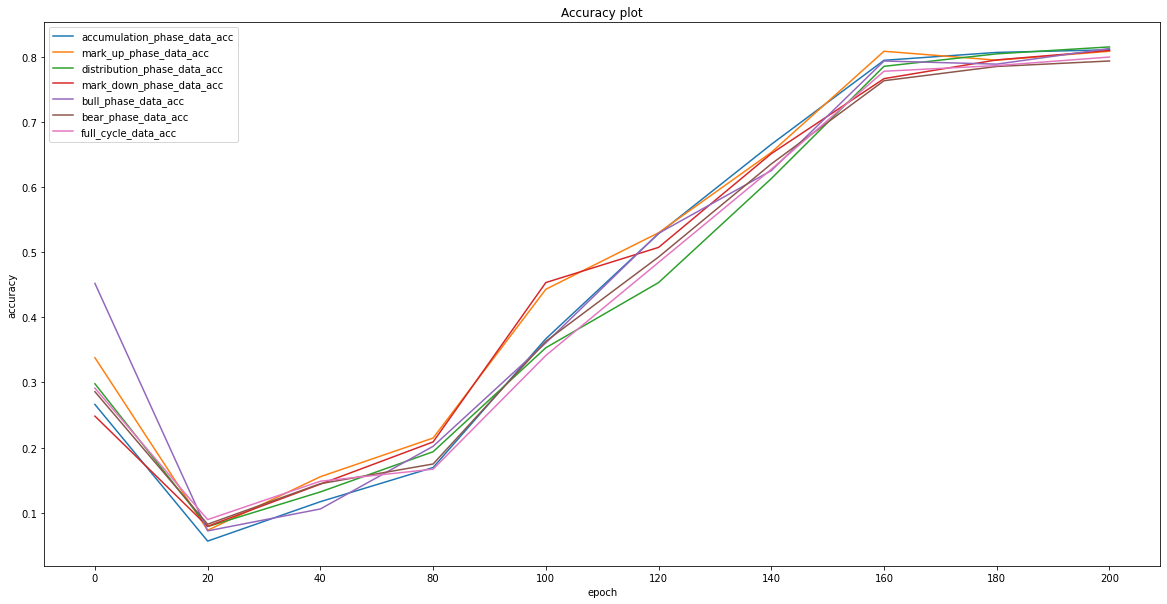

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(accumulation_phase_data_acc)
plt.plot(mark_up_phase_data_acc)
plt.plot(distribution_phase_data_acc)
plt.plot(mark_down_phase_data_acc)
plt.plot(bull_phase_data_acc)
plt.plot(bear_phase_data_acc)
plt.plot(full_cycle_data_acc)
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accumulation_phase_data_acc','mark_up_phase_data_acc','distribution_phase_data_acc','mark_down_phase_data_acc','bull_phase_data_acc','bear_phase_data_acc','full_cycle_data_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'full_cycle_data_correct_buys')

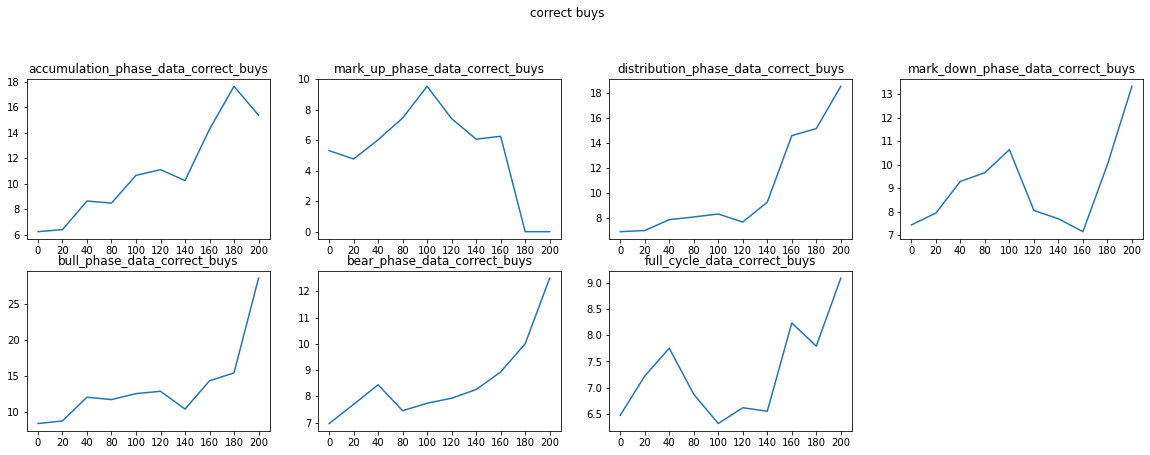

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_sells')

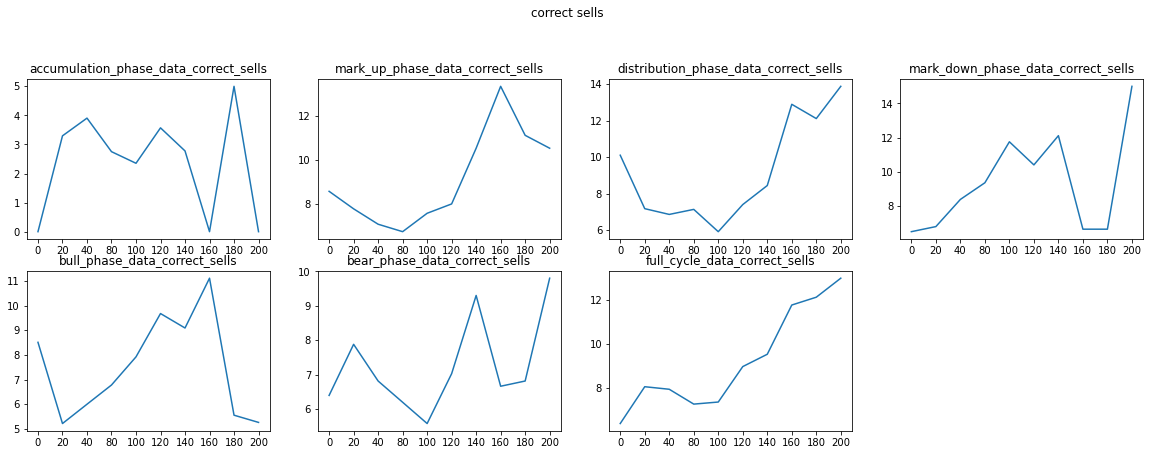

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_holds')

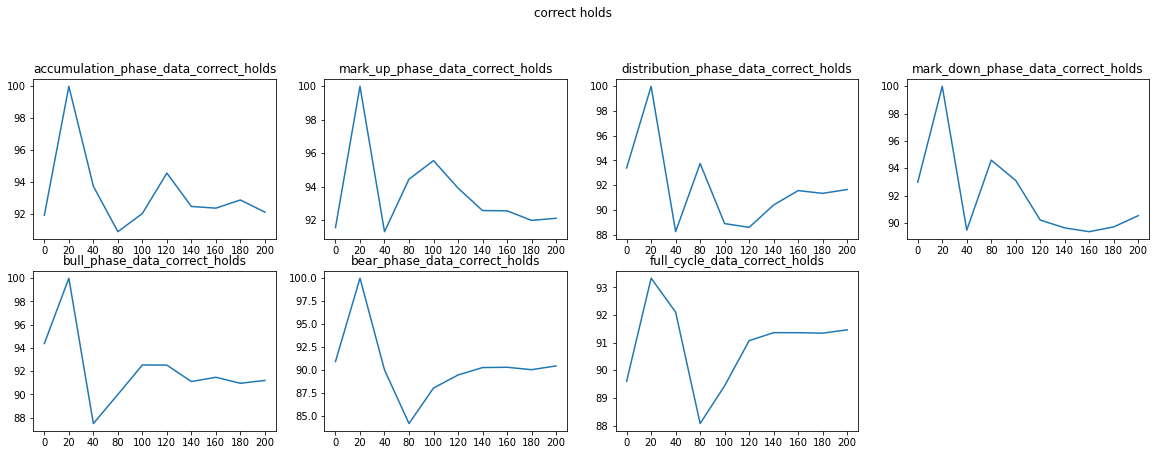

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_holds")

Text(0.5, 1.0, 'full_cycle_data_correct_low_buys')

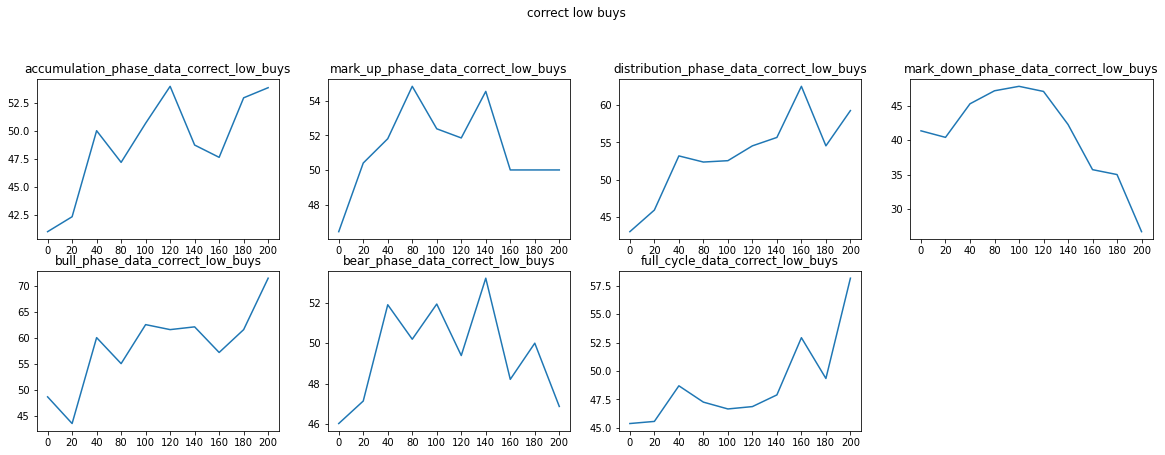

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct low buys")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_low_buys")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_low_buys")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_low_buys")

Text(0.5, 1.0, 'full_cycle_data_correct_high_sells')

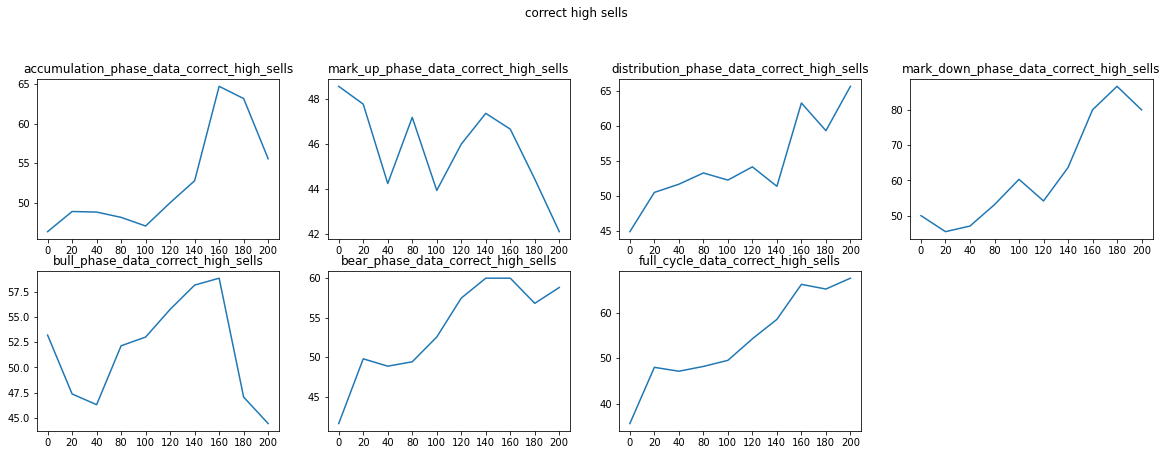

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct high sells")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_high_sells")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_high_sells")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_high_sells")

Text(0.5, 1.0, 'full_cycle_data_correct_mid_holds')

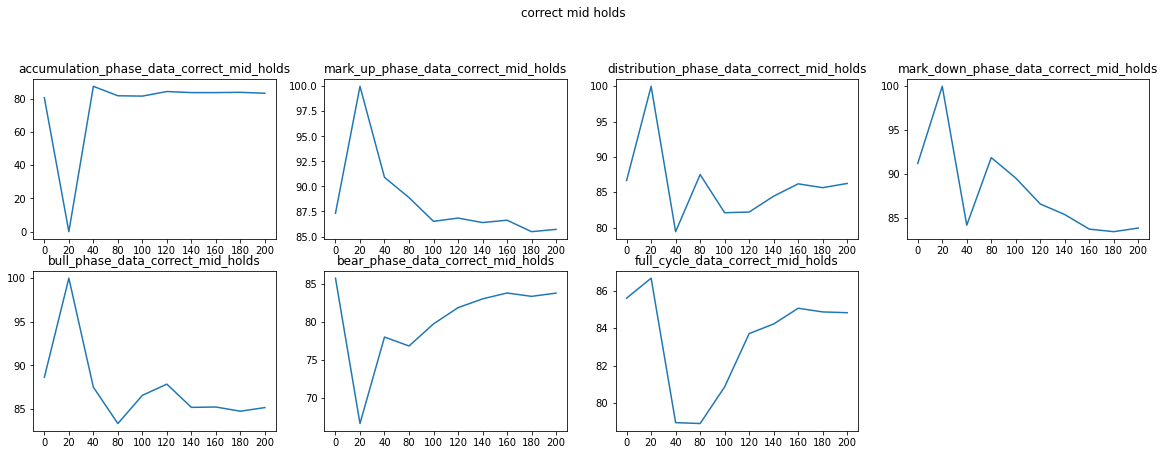

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_correct_mid_holds")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_correct_mid_holds")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_correct_mid_holds")

Text(0.5, 1.0, 'full_cycle_data_profit')

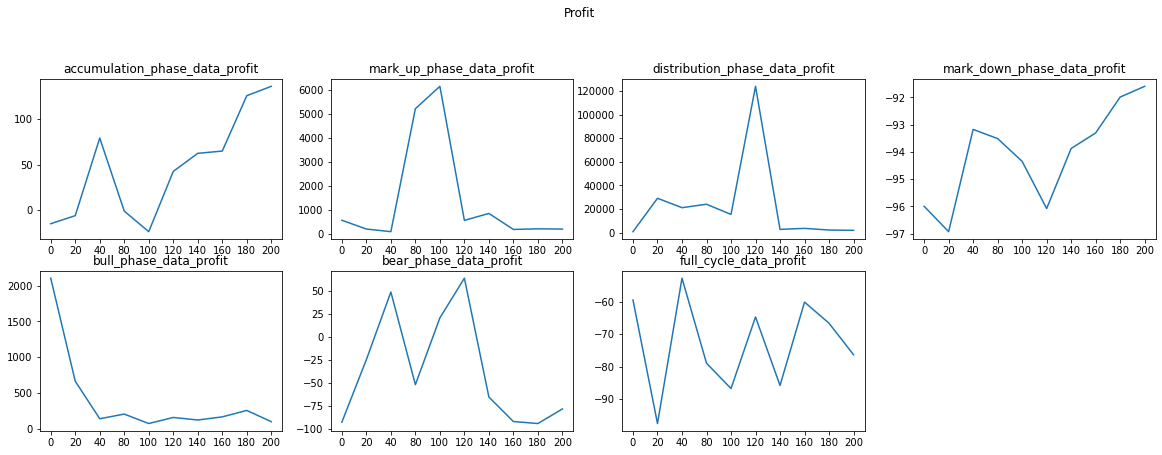

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Profit")

plt.subplot(3, 4, 1)
plt.plot(accumulation_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("accumulation_phase_data_profit")

plt.subplot(3, 4, 2)
plt.plot(mark_up_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_up_phase_data_profit")

plt.subplot(3, 4, 3)
plt.plot(distribution_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("distribution_phase_data_profit")

plt.subplot(3, 4, 4)
plt.plot(mark_down_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("mark_down_phase_data_profit")

plt.subplot(3, 4, 5)
plt.plot(bull_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bull_phase_data_profit")

plt.subplot(3, 4, 6)
plt.plot(bear_phase_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("bear_phase_data_profit")

plt.subplot(3, 4, 7)
plt.plot(full_cycle_data_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("full_cycle_data_profit")